In [2]:
import math 

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pylab as plt
from sklearn import datasets

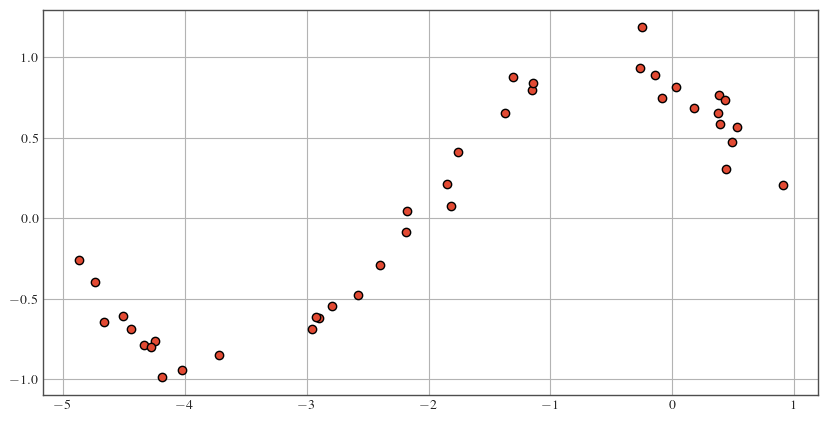

In [3]:
# X, y = datasets.make_moons(200, ) = 
X = torch.Tensor(40, 1).uniform_(-3, 3).float()
y = torch.sin(X).float()
y = y + torch.randn_like(y)*.1

X = (X - X.std(0)) - X.mean(0)
train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X.squeeze(), y)
plt.show()

In [5]:
from dal_toolbox.models.utils.variational_inference import BayesianLinear, BayesianConv2d

class Net(nn.Module):
    def __init__(self, prior_sigma=1) -> None:
        super().__init__()
        self.l1 = BayesianLinear(1, 50, prior_sigma=prior_sigma)
        self.l3 = BayesianLinear(50, 1, prior_sigma=prior_sigma)
        self.act = nn.Tanh()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.act(out)
        # out = self.l2(out)
        # kout = self.act(out)
        out = self.l3(out)
        return out

Epoch [1] [0/2] eta: 0:00:00 lr: 0.1 loss: 4.3901 (4.3901) nll: 0.6987 (0.6987) kl_loss: 3.6914 (3.6914) acc1: 100.0000 (100.0000) time: 0.0377 data: 0.0356 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.1 loss: 4.1677 (4.1677) nll: 0.4764 (0.4764) kl_loss: 3.6913 (3.6913) acc1: 100.0000 (100.0000) time: 0.0014 data: 0.0002 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.1 loss: 3.9718 (3.9718) nll: 0.2806 (0.2806) kl_loss: 3.6912 (3.6912) acc1: 100.0000 (100.0000) time: 0.0014 data: 0.0002 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.1 loss: 3.8952 (3.8952) nll: 0.2041 (0.2041) kl_loss: 3.6911 (3.6911) acc1: 100.0000 (100.0000) time: 0.0014 data: 0.0002 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.1 loss: 3.8599 (3.8599) nll: 0.1690 (0.1690) kl_loss: 3.6909 (3.6909) acc1: 100.0000 (100.0000) time: 0.0014 data: 0.0002 max mem: 0
Epoch [5] Total time: 0:00:00
Epoch [6] 

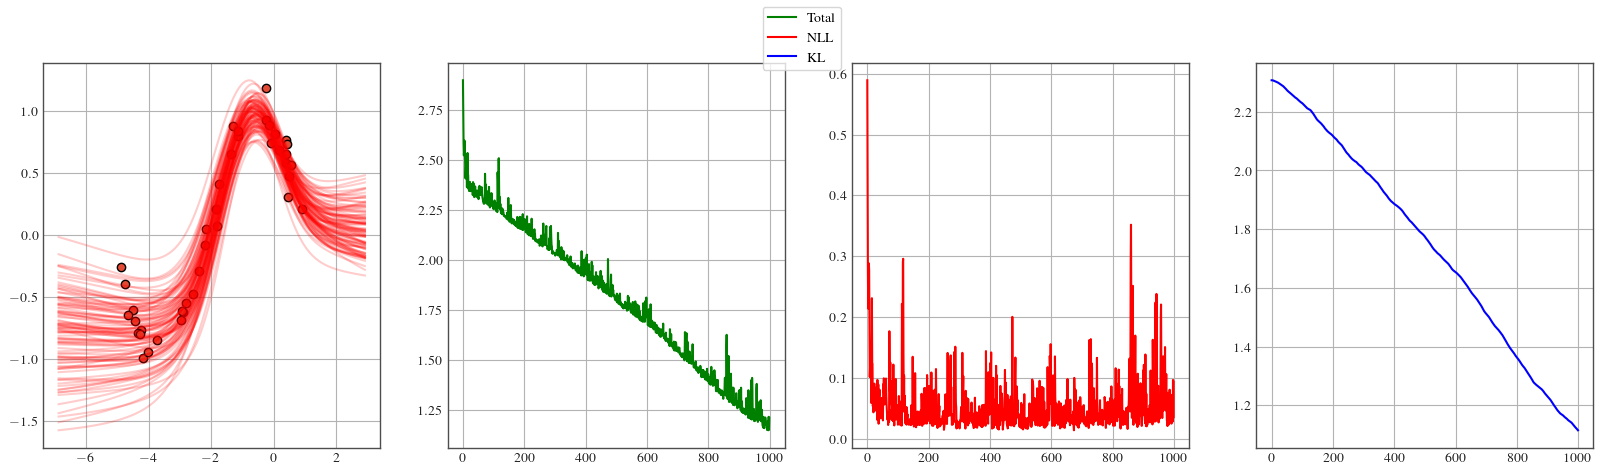

In [6]:
from dal_toolbox.models.variational_inference.trainer import VITrainer

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

model = Net(prior_sigma=1)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=0.9)

trainer = VITrainer(model, optimizer, criterion=nn.MSELoss(), kl_temperature=1)
train_stats = trainer.train(1000, train_loader)
train_history = train_stats['train_history']

fig = plt.figure(figsize=(20, 5))
axis = torch.linspace(X.min()-2, X.max()+2, 101)
with torch.no_grad():
    axis_pred = torch.stack([model(axis.view(-1, 1)).squeeze() for _ in range(100)], dim=-1)

plt.subplot(141)
plt.scatter(X, y)
plt.plot(axis, axis_pred, color='red', alpha=.2)
plt.subplot(142)
plt.plot([d['train_loss'] for d in train_history], label='Total', color='green')
plt.subplot(143)
plt.plot([d['train_nll'] for d in train_history], label='NLL', color='red')
plt.subplot(144)
plt.plot([d['train_kl_loss'] for d in train_history], label='KL', color='blue')
fig.legend(loc='upper center')
plt.show()


In [8]:
class BayesianCNN(nn.Module):
    def __init__(self, prior_sigma=1) -> None:
        super().__init__()
        self.conv1 = BayesianConv2d(1, 16, kernel_size=5, stride=2, prior_sigma=prior_sigma)
        self.conv2 = BayesianConv2d(16, 32, kernel_size=5, stride=2, prior_sigma=prior_sigma)
        self.l1 = BayesianLinear(512, 10, prior_sigma=prior_sigma)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = torch.flatten(out, start_dim=1)
        out = self.l1(out)
        return out
        
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.l1 = nn.Linear(512, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = torch.flatten(out, start_dim=1)
        out = self.l1(out)
        return out
        

Epoch [1] [  0/234] eta: 0:00:04 lr: 0.1 loss: 4.5963 (4.5963) nll: 2.2915 (2.2915) kl_loss: 2.3048 (2.3048) acc1: 16.4062 (16.4062) time: 0.0177 data: 0.0140 max mem: 9
Epoch [1] [200/234] eta: 0:00:00 lr: 0.1 loss: 1.3328 (1.6560) nll: 0.6328 (0.8230) kl_loss: 0.7004 (0.8330) acc1: 83.5938 (79.3902) time: 0.0164 data: 0.0123 max mem: 9
Epoch [1] Total time: 0:00:03
Epoch [2] [  0/234] eta: 0:00:03 lr: 0.1 loss: 1.2620 (1.2620) nll: 0.5626 (0.5626) kl_loss: 0.6994 (0.6994) acc1: 88.2812 (88.2812) time: 0.0168 data: 0.0133 max mem: 9
Epoch [2] [200/234] eta: 0:00:00 lr: 0.1 loss: 1.3232 (1.3402) nll: 0.6181 (0.6405) kl_loss: 0.7040 (0.6997) acc1: 83.5938 (83.7628) time: 0.0159 data: 0.0119 max mem: 9
Epoch [2] Total time: 0:00:03
Epoch [3] [  0/234] eta: 0:00:03 lr: 0.1 loss: 1.4207 (1.4207) nll: 0.7201 (0.7201) kl_loss: 0.7006 (0.7006) acc1: 81.2500 (81.2500) time: 0.0166 data: 0.0132 max mem: 9
Epoch [3] [200/234] eta: 0:00:00 lr: 0.1 loss: 1.3300 (1.3347) nll: 0.6357 (0.6354) kl_los

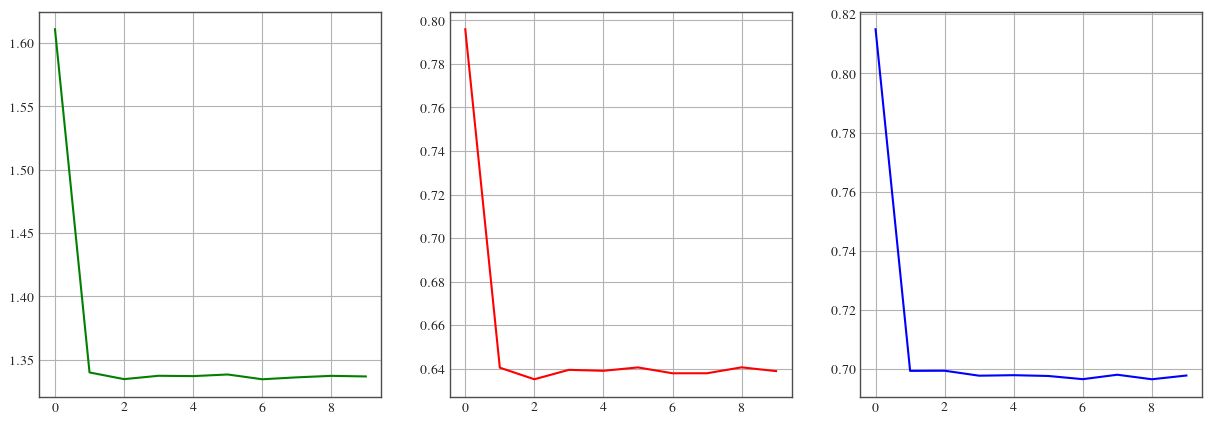

In [12]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_ds = MNIST('/tmp', True, transform=ToTensor(), download=True)
test_ds = MNIST('/tmp', False, transform=ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

device='cuda'

model = BayesianCNN(prior_sigma=1)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=0.9)
trainer = VITrainer(model, optimizer, criterion=nn.CrossEntropyLoss(), kl_temperature=1, device='cuda')
train_stats = trainer.train(10, train_loader)
train_history = train_stats['train_history']

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot([d['train_loss'] for d in train_history], label='Total', color='green')
plt.subplot(132)
plt.plot([d['train_nll'] for d in train_history], label='NLL', color='red')
plt.subplot(133)
plt.plot([d['train_kl_loss'] for d in train_history], label='KL', color='blue')
fig.legend(loc='upper center')
plt.show()

In [13]:
trainer.evaluate(test_loader)

{'test_loss': 163.15162658691406,
 'test_acc1': 85.18000030517578,
 'test_nll': 0.6110367774963379,
 'test_brier': 0.27080923318862915,
 'test_tce': 0.18709257245063782,
 'test_mce': 0.07900478690862656}